In [7]:
from constants import * 

ch_names = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
            'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'Oz']

ch_subset = ['C3', 'Cz', 'C4',  # Central electrodes over the sensorimotor cortex 
             'FC1', 'FC2', 'FC3', 'FC4',  # Frontal-central electrodes 
             'CP1', 'CP2', 'CP3', 'CP4'   # Centro-parietal electrodes
            ]
selected_ch_idx = np.array([ch_name in ch_subset for ch_name in ch_names]) 
n_channels = 11

In [3]:
data_path = '/Users/seonghyunyoon/Developer/cp-eeg/Data/2aiv/'
save_path = '/Users/seonghyunyoon/Developer/conformal_prediction_bmi/test 4 (few channels)/'
model_path = f'{save_path}/saved_models/'

In [7]:
all_X_train = [] 
all_y_train = [] 
all_X_val = []
all_y_val = []
all_X_test = []
all_y_test = []

all_models = [] 

for subject_num in tqdm(range(1, 10)): 
    # Load data 
    X_train, y_train = get_data(subject_num, training=True, path=data_path)
    X_val_test, y_val_test = get_data(subject_num, training=False, path=data_path)
    X_train, y_train = prepare_features(X_train, y_train)
    X_val_test, y_val_test = prepare_features(X_val_test, y_val_test)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=.65, random_state=42)
    
    X_train = X_train[:,:,selected_ch_idx,:]
    X_val = X_val[:,:,selected_ch_idx,:]
    X_test = X_test[:,:,selected_ch_idx,:]

    # Scale the data
    for j in range(n_channels):
        scaler = StandardScaler()
        scaler.fit(X_train[:,0,j,:])
        X_train[:,0,j,:] = scaler.transform(X_train[:,0,j,:])
        X_val[:,0,j,:] = scaler.transform(X_val[:,0,j,:])
        X_test[:,0,j,:] = scaler.transform(X_test[:,0,j,:])
    
    # Append to total data 
    all_X_train.append(X_train)
    all_y_train.append(y_train)
    all_X_val.append(X_val)
    all_y_val.append(y_val)
    all_X_test.append(X_test)
    all_y_test.append(y_test)
    
    # Prepare model
    curr_model_path = f'{model_path}/model_{subject_num}.h5'
    _, _, n_channels, n_time = X_train.shape
    n_classes = y_train.shape[1]
    model = EEGTCNet(nb_classes = n_classes, Chans=n_channels, Samples=n_time, layers=L, kernel_s=KT, filt=FT, dropout=pt, activation='elu', 
                     F1=F1, D=2, kernLength=KE, dropout_eeg=pe)
    model.load_weights(curr_model_path)
    all_models.append(model)

  0%|          | 0/9 [00:00<?, ?it/s]

## P values

In [8]:
from scipy.stats import kstest

n_iters = 100

np.random.seed(42) 

pvalues = np.zeros((9, 100, n_iters))
sample_percentages = list(np.arange(0.01, 1.01, 0.01)) 

for subject_num in tqdm(range(9)): 
    model = all_models[subject_num]
    X_val = all_X_val[subject_num]; y_val = all_y_val[subject_num]
    X_test = all_X_test[subject_num]; y_test = all_y_test[subject_num]
    n_val = X_val.shape[0]
    val_smx = model.predict(X_val); test_smx = model.predict(X_test, verbose=False)
    
    for percentage_idx, val_percentage in enumerate(sample_percentages):
        curr_n_val = int(np.ceil(n_val * val_percentage))  # Ceil to avoid empty set 
        for i in range(n_iters): 
            random_indices = np.random.choice(n_val, size=curr_n_val, replace=False)
            val_score, test_score = get_conformity_scores(val_smx[random_indices], y_val[random_indices], test_smx, y_test)
            pvalues[subject_num, percentage_idx, i] = kstest(val_score, test_score)[1]

np.save(f'{save_path}/pvalues.npy', pvalues)

  0%|          | 0/9 [00:00<?, ?it/s]

6/6 [==============================] - 0s 8ms/step


In [4]:
pvalues = np.load(f'{save_path}/pvalues.npy')

Does not reach p < 0.05


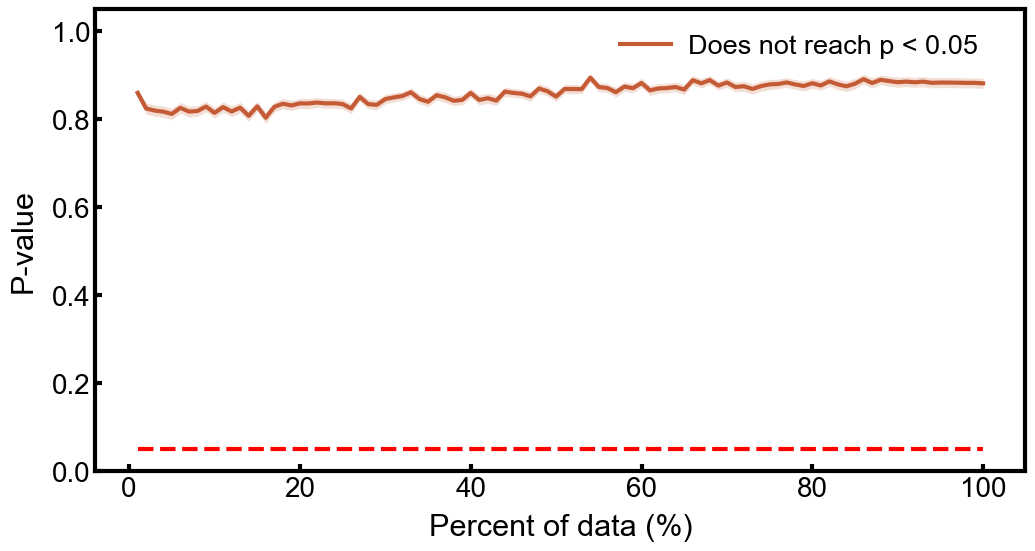

In [8]:
pvalues_reshaped = pvalues.transpose(0, 2, 1)
pvalues_reshaped = pvalues_reshaped.reshape((pvalues.shape[0] * pvalues.shape[2], pvalues.shape[1]))
plot_average_pval(pvalues_reshaped)  # Bit of indexing magic

## Safety analysis

In [10]:
# True labels are treated as when the classifier gives us correct labels VS incorrect labels. 
# I.e., the CP abstaining framework is treated like a binary classifier on when to abstain or not. 

np.random.seed(42)

all_alphas = list(np.arange(0.01, 1.00, 0.01))

n_iters = 100
true_positives = np.zeros((9, len(all_alphas), n_iters)); true_negatives = np.zeros((9, len(all_alphas), n_iters))
false_positives = np.zeros((9, len(all_alphas), n_iters)); false_negatives = np.zeros((9, len(all_alphas), n_iters))
baseline_accuracies = np.zeros((9,))

for subject_num in tqdm(range(9)): 
    model = all_models[subject_num]
    X_val = all_X_val[subject_num]; y_val = all_y_val[subject_num]
    X_test = all_X_test[subject_num]; y_test = all_y_test[subject_num]
    val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
    true_abstain = test_smx.argmax(1) != y_test.argmax(1); true_noabstain = ~true_abstain
    baseline_accuracies = np.mean(true_noabstain)
    for i_alpha, alpha in enumerate(all_alphas): 
        for j in range(n_iters): 
            ps, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=1-alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=True, verbose=False)
            pred_abstain = np.sum(ps, axis=1) > 1; pred_noabstain = np.sum(ps, axis=1) == 1
            tp = np.sum(np.logical_and(pred_abstain, true_abstain)); fp = np.sum(np.logical_and(pred_abstain, true_noabstain))
            fn = np.sum(np.logical_and(pred_noabstain, true_abstain)); tn = np.sum(np.logical_and(pred_noabstain, true_noabstain))
            assert tp + fp + fn + tn == X_test.shape[0]
                
            true_positives[subject_num, i_alpha, j] = tp
            true_negatives[subject_num, i_alpha, j] = tn
            false_positives[subject_num, i_alpha, j] = fp
            false_negatives[subject_num, i_alpha, j] = fn

np.save(f'{save_path}true_positives.npy', true_positives)
np.save(f'{save_path}true_negatives.npy', true_negatives)
np.save(f'{save_path}false_positives.npy', false_positives)
np.save(f'{save_path}false_negatives.npy', false_negatives)

  0%|          | 0/9 [00:00<?, ?it/s]

In [11]:
tpr = np.zeros((9 * n_iters, len(all_alphas)))
fpr = np.zeros((9 * n_iters, len(all_alphas)))
precision = np.zeros((9 * n_iters, len(all_alphas)))

for subject_num in range(9):
    for i in range(n_iters): 
        save_idx = subject_num*n_iters + i
        tpr[save_idx,:] = true_positives[subject_num,:,i] / (true_positives[subject_num,:,i] + false_negatives[subject_num,:,i])
        fpr[save_idx,:] = false_positives[subject_num,:,i] / (true_negatives[subject_num,:,i] + false_positives[subject_num,:,i])
        precision_array = true_positives[subject_num,:,i] / (true_positives[subject_num,:,i] + false_positives[subject_num,:,i])
        precision_array[np.isnan(precision_array)] = 1  
        precision[save_idx,:] = precision_array

/var/folders/_z/_4jv4z3n0gs0lmmsrf6xf1sr0000gn/T/ipykernel_61251/1331240567.py:10: RuntimeWarning: invalid value encountered in divide
  precision_array = true_positives[subject_num,:,i] / (true_positives[subject_num,:,i] + false_positives[subject_num,:,i])


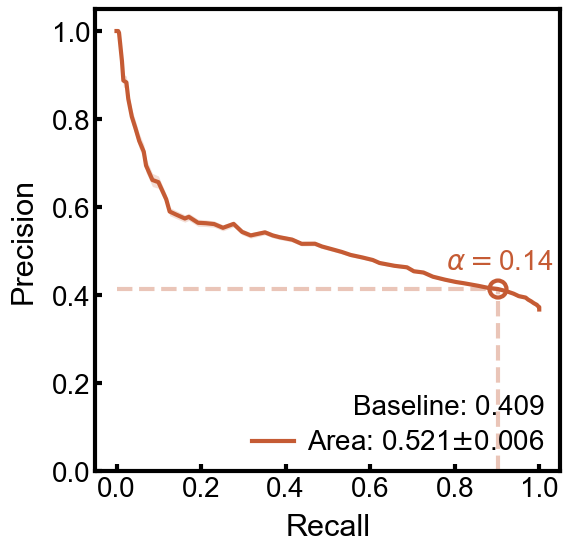

In [18]:
plot_prcurve(tpr, precision, baseline_accuracies=baseline_accuracies, x_adj=0.13, y_adj=0.09)

Area under the curve: 0.6402487170570984 $\plusminus$ 0.00510284892058932


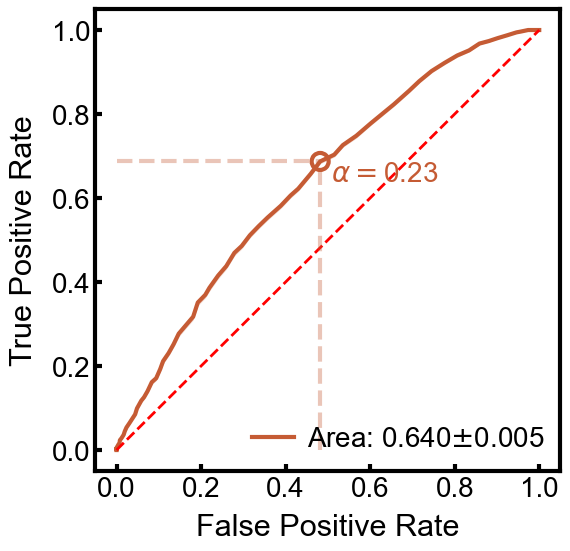

In [19]:
plot_roccurve(fpr, tpr, x_adj=0.28, y_adj=0.0)

In [20]:
# Prepare all values of alphas 
all_alphas = np.arange(0.01, 0.99, 0.01)
n_alphas = len(all_alphas)
n_iters = 100
n_classes = 4

empirical_coverages = np.zeros((9 * n_iters, n_alphas))
accuracies = np.zeros((9 * n_iters, n_alphas))
prediction_rates = np.zeros((9 * n_iters, n_alphas))

baseline_accuracy = np.zeros((9,))

for subject_num in tqdm(range(9)): 
    # Load Relevant model and data
    model = all_models[subject_num]
    X_val = all_X_val[subject_num]; y_val = all_y_val[subject_num]
    X_test = all_X_test[subject_num]; y_test = all_y_test[subject_num]
    val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
    
    for i_alpha, alpha in enumerate(all_alphas): 
        for i_iter in range(n_iters): 
            save_idx = subject_num*n_iters + i_iter
            pred_set, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=False)
            empirical_coverages[save_idx, i_alpha] = get_coverage(y_test, pred_set)

            pred_set, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=True)
            set_size = get_set_size(pred_set, n_classes)
            prediction_rates[save_idx, i_alpha] = (set_size[0] + set_size[1]) / sum(set_size.values())
            accuracies[save_idx, i_alpha] = get_abstain_metrics(pred_set, test_smx, y_test, verbose=False)
        
    baseline_accuracy[subject_num] = np.mean(test_smx.argmax(1) == y_test.argmax(1))
    
np.save(f'{save_path}baseline_accuracies.npy', baseline_accuracy)
np.save(f'{save_path}empirical_coverages.npy', empirical_coverages)
np.save(f'{save_path}accuracies.npy', accuracies)
np.save(f'{save_path}prediction_rates.npy', prediction_rates)

  0%|          | 0/9 [00:00<?, ?it/s]

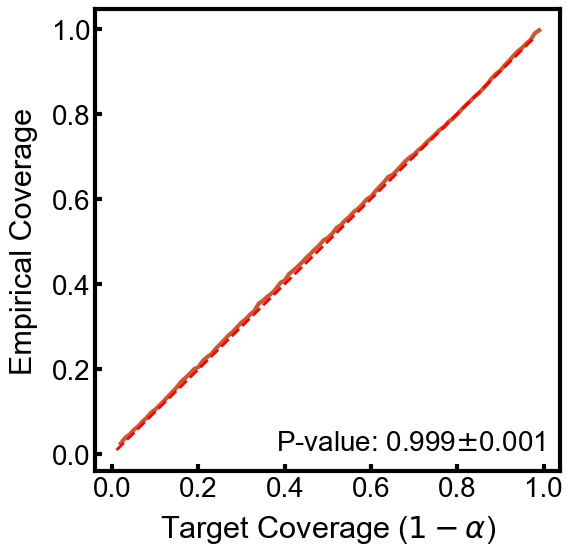

In [21]:
plot_average_coverage(empirical_coverages)

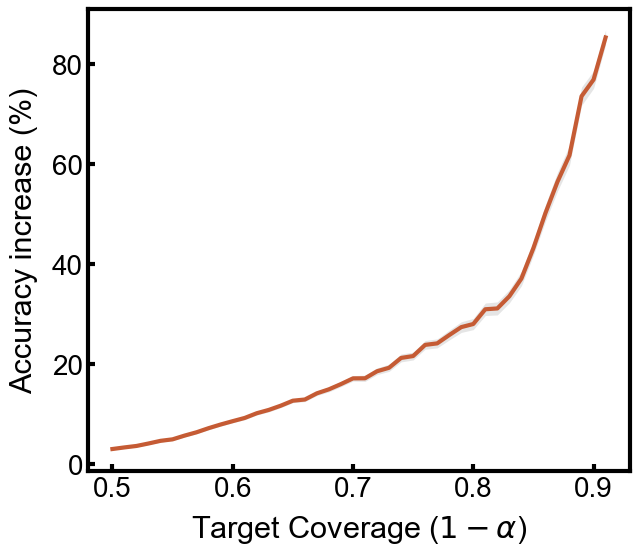

In [22]:
acc_improvement, acc_avg, acc_ci_lower, acc_ci_upper = plot_average(np.expand_dims(accuracies, axis=0), plot_type='accuracies', 
                                                                    baseline_accuracy=baseline_accuracy, n_iters=100)

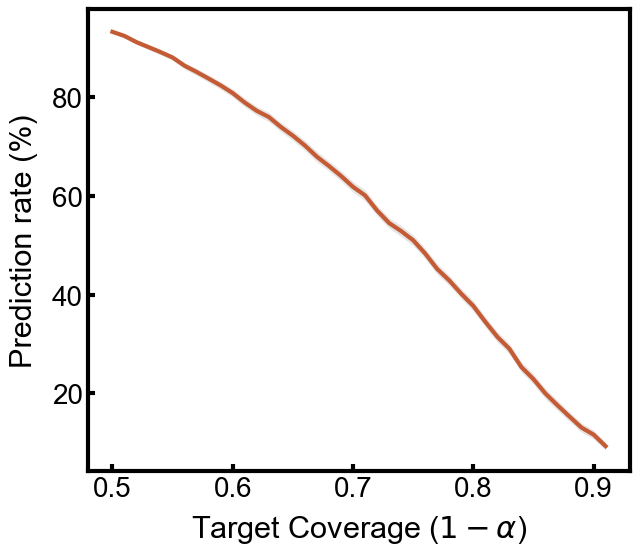

In [23]:
pr_avg, pr_ci_lower, pr_ci_upper = plot_average(np.expand_dims(prediction_rates, axis=0), plot_type='prediction_rates')

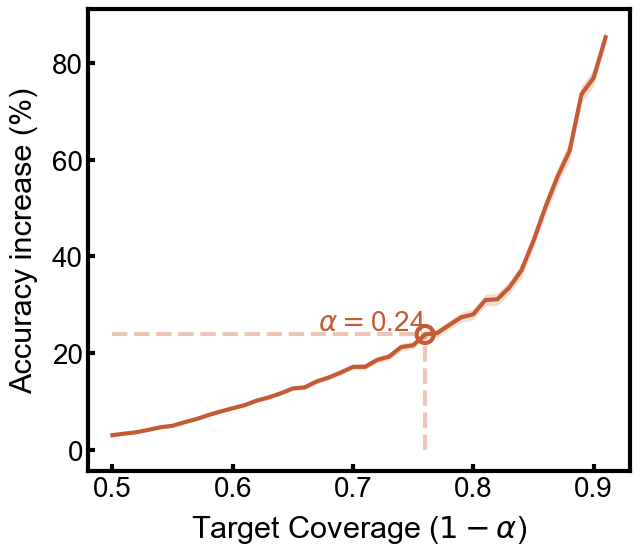

In [24]:
alpha_max = normalized_f1_score(acc_improvement.T, pr_avg)
plot_average_with_optimum(acc_avg, acc_ci_lower, acc_ci_upper, plot_type='accuracies', max_alpha_idx=alpha_max, x_adj=-0.0, y_adj=5)

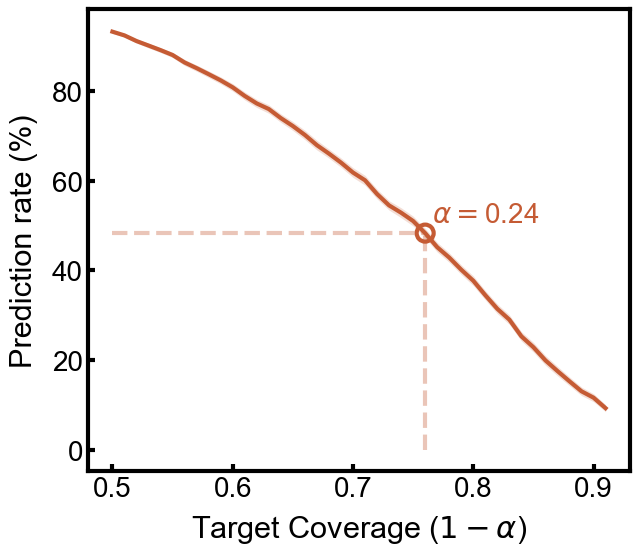

In [25]:
plot_average_with_optimum(pr_avg, pr_ci_lower, pr_ci_upper, plot_type='prediction_rates', max_alpha_idx=alpha_max, x_adj=0.095, y_adj=7)

## What if calibration data is from the target distribution?